# Условие задачи

Кто там? Предскажите, кто вошел в здание по времени и турникету. Но теперь легче: мы знаем, что "след" через турникеты принадлежит "Х". Кто этот "Х" предстоит вычислить по данным, которые нам известны. А ID юзеров известны по обучающей выборке (кроме нескольких новых!).
Чтобы попасть в здание, нужно пройти через турникет. Чтобы открыть парковку, нужно открыть шлагбаум. Чтобы попасть на этаж, нужно приложить “таблетку”. Все это фиксируется - кто, в какую дату, в какое время.
Сможем ли мы выучить кому конкретно принадлежит след прохода через турникеты? Теперь мы знаем, что это был кто-то, кто уже был. (Правда, есть и несколько - не больше 10% - новых).
“8 утра понедельник, турникет 4? Директор.” “11 утра суббота? Гриша. Но Гриша в последний день месяца никогда не приходит.”  Какие есть паттерны в настоящих данных?

В тестовой выборке id посетителей заменены на слова, которые встречались в курсе "Линейные модели": aucroc, binary, blue, categorical и т.п.
Ваша задача в этом раунде составить таблицу вида:
```
user_word	preds
aucroc	49
binary	12
blue	55
categorical	-999
coefficient	15
```
где user_word - index, preds - колонка с соответствующими id. Таблицу нужно запомнить как csv (см. пример в секции Data). -999 – id нового посетителя, которого раньше не было.
Каждому слову сопоставлен вес, который зависит от того, насколько трудно предсказать id. Баллы набираются как взвешенная по весам сумма правильных ответов. Чем сложнее вы отгадали слово, тем больше баллов.

Отгадали все? Забирайте 560 баллов и становитесь победителем.

Используем деревья и ансамбли.

In [1]:
import pandas as pd

In [2]:
input_train_df = pd.read_csv('train.csv', index_col=0)
input_train_df.ts = pd.to_datetime(input_train_df.ts)
input_test_df = pd.read_csv('test.csv', index_col = 0)
input_test_df.ts = pd.to_datetime(input_test_df.ts)

In [3]:
input_train_df

,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
...,...,...,...
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6
37516,6,2022-12-31 20:39:31,9


In [13]:
train_df = pd.DataFrame(input_train_df)
test_df = pd.DataFrame(input_test_df)
train_df['Time'] = train_df['ts'].apply(lambda x: x.timestamp())
train_df['Year'] = train_df['ts'].dt.year
train_df['Month'] = train_df['ts'].dt.month
train_df['Day'] = train_df['ts'].dt.day
train_df['Hour'] = train_df['ts'].dt.hour
train_df['Time(unix)'] = (train_df['ts'] - pd.to_datetime(train_df['ts'].dt.date)).dt.total_seconds()
#train_df['DayPosition'] = train_df['ts'].dt.dayofweek
train_df['IsWorkDay'] = train_df['ts'].dt.weekday < 5
train_df['IsWorkDay'] = train_df['IsWorkDay'].astype(int)
#
test_df['Time'] = test_df['ts'].apply(lambda x: x.timestamp())
test_df['Year'] = test_df['ts'].dt.year
test_df['Month'] = test_df['ts'].dt.month
test_df['Day'] = test_df['ts'].dt.day
test_df['Hour'] = test_df['ts'].dt.hour
test_df['Time(unix)'] = (test_df['ts'] - pd.to_datetime(test_df['ts'].dt.date)).dt.total_seconds()
#test_df['DayPosition'] = test_df['ts'].dt.dayofweek
test_df['IsWorkDay'] = test_df['ts'].dt.weekday < 5
test_df['IsWorkDay'] = test_df['IsWorkDay'].astype(int)

Сделаем категориальные фичи для дней, часов и ворот

In [14]:
# Ворота
unique_gates = sorted(list(train_df['gate_id'].unique()))
gates_ids = pd.get_dummies(train_df['gate_id']).values
train_df[[f'gate_{i}' for i in unique_gates]] = gates_ids

unique_gates = sorted(list(test_df['gate_id'].unique()))
gates_ids = pd.get_dummies(test_df['gate_id']).values
test_df[[f'gate_{i}' for i in unique_gates]] = gates_ids
# Дни
day_list = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
train_df[day_list] = pd.get_dummies(train_df['ts'].dt.day_name())[day_list].values
test_df[day_list] = pd.get_dummies(test_df['ts'].dt.day_name())[day_list].values
# Часы
train_df[[f'Hour_{i}' for i in sorted(list(train_df['Hour'].unique()))] ] = \
    pd.get_dummies(train_df['Hour'].values).values
test_df[[f'Hour_{i}' for i in sorted(list(test_df['Hour'].unique()))] ] = \
    pd.get_dummies(test_df['Hour'].values).values


In [15]:
train_df

,user_id,ts,gate_id,Time,Year,Month,Day,Hour,Time(unix),IsWorkDay,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,18,2022-07-29 09:08:54,7,1.659086e+09,2022,7,29,9,32934.0,1,...,False,False,False,False,False,False,False,False,False,False
1,18,2022-07-29 09:09:54,9,1.659086e+09,2022,7,29,9,32994.0,1,...,False,False,False,False,False,False,False,False,False,False
2,18,2022-07-29 09:09:54,9,1.659086e+09,2022,7,29,9,32994.0,1,...,False,False,False,False,False,False,False,False,False,False
3,18,2022-07-29 09:10:06,5,1.659086e+09,2022,7,29,9,33006.0,1,...,False,False,False,False,False,False,False,False,False,False
4,18,2022-07-29 09:10:08,5,1.659086e+09,2022,7,29,9,33008.0,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37513,6,2022-12-31 20:38:56,11,1.672519e+09,2022,12,31,20,74336.0,0,...,False,False,False,False,False,False,True,False,False,False
37514,6,2022-12-31 20:39:22,6,1.672519e+09,2022,12,31,20,74362.0,0,...,False,False,False,False,False,False,True,False,False,False
37515,6,2022-12-31 20:39:23,6,1.672519e+09,2022,12,31,20,74363.0,0,...,False,False,False,False,False,False,True,False,False,False
37516,6,2022-12-31 20:39:31,9,1.672519e+09,2022,12,31,20,74371.0,0,...,False,False,False,False,False,False,True,False,False,False


In [16]:
train_df = train_df.drop_duplicates(subset=['ts', 'user_id'])
test_df = test_df.drop_duplicates(subset=['ts', 'user_word'])

In [17]:
train_df

,user_id,ts,gate_id,Time,Year,Month,Day,Hour,Time(unix),IsWorkDay,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,18,2022-07-29 09:08:54,7,1.659086e+09,2022,7,29,9,32934.0,1,...,False,False,False,False,False,False,False,False,False,False
1,18,2022-07-29 09:09:54,9,1.659086e+09,2022,7,29,9,32994.0,1,...,False,False,False,False,False,False,False,False,False,False
3,18,2022-07-29 09:10:06,5,1.659086e+09,2022,7,29,9,33006.0,1,...,False,False,False,False,False,False,False,False,False,False
4,18,2022-07-29 09:10:08,5,1.659086e+09,2022,7,29,9,33008.0,1,...,False,False,False,False,False,False,False,False,False,False
5,18,2022-07-29 09:10:34,10,1.659086e+09,2022,7,29,9,33034.0,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37512,6,2022-12-31 17:21:19,10,1.672507e+09,2022,12,31,17,62479.0,0,...,False,False,False,True,False,False,False,False,False,False
37513,6,2022-12-31 20:38:56,11,1.672519e+09,2022,12,31,20,74336.0,0,...,False,False,False,False,False,False,True,False,False,False
37514,6,2022-12-31 20:39:22,6,1.672519e+09,2022,12,31,20,74362.0,0,...,False,False,False,False,False,False,True,False,False,False
37515,6,2022-12-31 20:39:23,6,1.672519e+09,2022,12,31,20,74363.0,0,...,False,False,False,False,False,False,True,False,False,False


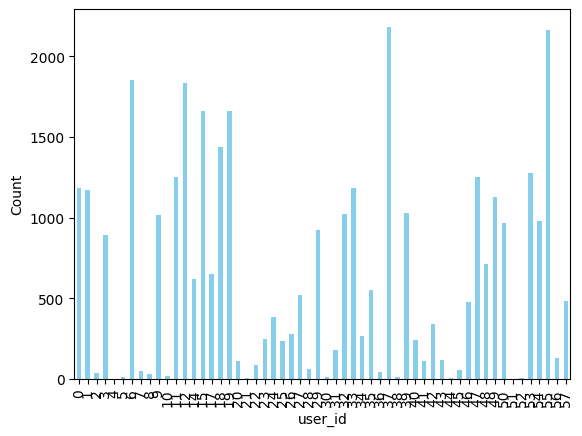

In [18]:
import matplotlib.pyplot as plt

train_df['user_id'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('user_id')
plt.ylabel('Count')
plt.show()

13 и 16 отсутствуют!

In [38]:
train_X = train_df[list(train_df.columns[5:])]
train_Y = train_df[train_df.columns[0]]

In [68]:
train_X.columns

Index(['Month', 'Day', 'Hour', 'Time(unix)', 'IsWorkDay', 'gate_-1', 'gate_0',
       'gate_1', 'gate_3', 'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8',
       'gate_9', 'gate_10', 'gate_11', 'gate_12', 'gate_13', 'gate_14',
       'gate_15', 'gate_16', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
       'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
       'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
       'Hour_22', 'Hour_23', 'Hour_0', 'Hour_1', 'Hour_3', 'gate_2'],
      dtype='object')

In [69]:
train_X.head()

,Month,Day,Hour,Time(unix),IsWorkDay,gate_-1,gate_0,gate_1,gate_3,gate_4,...,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Hour_0,Hour_1,Hour_3,gate_2
0,7,29,9,32934.0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,7,29,9,32994.0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,7,29,9,33006.0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,7,29,9,33008.0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,7,29,9,33034.0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [40]:
train_Y

0        18
1        18
3        18
4        18
5        18
         ..
37512     6
37513     6
37514     6
37515     6
37516     6
Name: user_id, Length: 35170, dtype: int64

In [89]:
test_df

,ts,gate_id,user_word,Time,Year,Month,Day,Hour,Time(unix),IsWorkDay,...,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,predicted_user_id
37518,2023-01-03 08:21:00,9,gini,1.672734e+09,2023,1,3,8,30060.0,1,...,False,False,False,False,False,False,False,False,False,18
37520,2023-01-03 08:21:18,5,gini,1.672734e+09,2023,1,3,8,30078.0,1,...,False,False,False,False,False,False,False,False,False,15
37521,2023-01-03 08:21:19,5,gini,1.672734e+09,2023,1,3,8,30079.0,1,...,False,False,False,False,False,False,False,False,False,15
37522,2023-01-03 08:21:39,10,gini,1.672734e+09,2023,1,3,8,30099.0,1,...,False,False,False,False,False,False,False,False,False,18
37523,2023-01-03 08:32:49,15,epsilon,1.672735e+09,2023,1,3,8,30769.0,1,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44637,2023-02-24 17:08:57,10,collinear,1.677259e+09,2023,2,24,17,61737.0,1,...,False,False,True,False,False,False,False,False,False,14
44638,2023-02-24 19:43:36,11,collinear,1.677268e+09,2023,2,24,19,71016.0,1,...,False,False,False,False,True,False,False,False,False,17
44639,2023-02-24 19:44:00,4,collinear,1.677268e+09,2023,2,24,19,71040.0,1,...,False,False,False,False,True,False,False,False,False,17
44640,2023-02-24 19:44:01,4,collinear,1.677268e+09,2023,2,24,19,71041.0,1,...,False,False,False,False,True,False,False,False,False,17


In [64]:
for_predict = test_df[list(test_df.columns[5:])]

In [74]:
def add_missing_columns(df, columns):
    for col in columns:
        if col not in df.columns:
            df.loc[:, col] = False
    return df.reindex(sorted(df.columns), axis = 1)

In [75]:
# Получаем список всех уникальных столбцов из обоих датафреймов
all_columns = set(train_X.columns).union(for_predict.columns)

# Добавляем недостающие столбцы в оба датафрейма
train_X = add_missing_columns(train_X, all_columns)
for_predict = add_missing_columns(for_predict, all_columns)

In [76]:
for_predict.columns

Index(['Day', 'Friday', 'Hour', 'Hour_0', 'Hour_1', 'Hour_10', 'Hour_11',
       'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17',
       'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23',
       'Hour_3', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'IsWorkDay', 'Monday',
       'Month', 'Saturday', 'Sunday', 'Thursday', 'Time(unix)', 'Tuesday',
       'Wednesday', 'gate_-1', 'gate_0', 'gate_1', 'gate_10', 'gate_11',
       'gate_12', 'gate_13', 'gate_14', 'gate_15', 'gate_16', 'gate_2',
       'gate_3', 'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8', 'gate_9'],
      dtype='object')

In [77]:
for_predict.head()

,Day,Friday,Hour,Hour_0,Hour_1,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,...,gate_15,gate_16,gate_2,gate_3,gate_4,gate_5,gate_6,gate_7,gate_8,gate_9
37518,3,False,8,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
37520,3,False,8,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
37521,3,False,8,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
37522,3,False,8,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37523,3,False,8,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [78]:
from sklearn.preprocessing import StandardScaler

scaler_train_X = StandardScaler()
scaler_for_pred= StandardScaler()

scaler_train_X.fit(train_X)
scaler_for_pred.fit(for_predict)

train_X_scaled = scaler_train_X.transform(train_X)
for_pred_scaled = scaler_for_pred.transform(for_predict)

In [79]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state = 1, solver='saga')

In [80]:
model = model.fit(train_X_scaled, train_Y)

C:\Users\Skiv2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [81]:
y_pred = model.predict(for_pred_scaled)

In [83]:
y_pred

array([18, 15, 15, ..., 17, 17, 14], dtype=int64)

In [94]:
test_df['predicted_user_id'] = y_pred

In [95]:
len(test_df)

6620

In [96]:
result = test_df.groupby(['user_word', 'predicted_user_id']).size().reset_index(name = 'count')
result = result.rename(columns={'size': 'count'})
result = result.sort_values(['user_word', 'count'], ascending=[True, False])
result = result.drop_duplicates(subset='user_word', keep='first')

In [86]:
print(result[['user_word', 'predicted_user_id']])

        user_word  predicted_user_id
6          aucroc                 49
11         binary                 12
29           blue                 55
35    categorical                 14
52    coefficient                 15
64      collinear                 12
85    distributed                 12
94        epsilon                  1
135            f1                 37
144           fit                  1
168          gini                 15
182   independent                  1
203         lasso                 15
229        linear                 55
230      logistic                 12
241          loss                 19
256        matrix                 12
276  minimization                 12
304           mse                 55
316           ols                 37
330     precision                 55
336       predict                 12
370        pvalue                 53
377            r2                 12
394        recall                  3
418    regression                 55
4

In [98]:
# Группируем данные по user_word и predicted_user_id, затем выбираем наиболее часто встречающийся user_id
result = test_df.groupby(['user_word', 'predicted_user_id']).size().reset_index(name='count')
result = result.rename(columns={'size': 'count'})

In [99]:
result

,user_word,predicted_user_id,count
0,aucroc,1,2
1,aucroc,3,4
2,aucroc,11,4
3,aucroc,12,11
4,aucroc,24,2
...,...,...,...
564,y,25,1
565,y,33,4
566,y,35,2
567,y,37,4


In [100]:
# Формируем таблицу с желаемым форматом вывода
pivot_result = result.pivot_table(index='user_word', columns='predicted_user_id', values='count', fill_value=0)

# Нормализуем значения в таблице, деля на общее количество для каждого user_word
pivot_result = pivot_result.div(pivot_result.sum(axis=1), axis=0)

In [101]:
# Выведем результаты
print(pivot_result)

predicted_user_id        0         1         3         6         9         11  \
user_word                                                                       
aucroc             0.000000  0.054054  0.108108  0.000000  0.000000  0.108108   
binary             0.000000  0.000000  0.008287  0.011050  0.013812  0.038674   
blue               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
categorical        0.000000  0.024490  0.028571  0.008163  0.000000  0.114286   
coefficient        0.000000  0.017857  0.071429  0.053571  0.000000  0.035714   
collinear          0.000000  0.010067  0.013423  0.016779  0.006711  0.033557   
distributed        0.000000  0.000000  0.059829  0.000000  0.017094  0.196581   
epsilon            0.000000  0.136905  0.083333  0.008929  0.011905  0.041667   
f1                 0.004323  0.020173  0.007205  0.087896  0.005764  0.028818   
fit                0.000000  0.295082  0.207650  0.000000  0.016393  0.071038   
gini               0.000000 

In [102]:

result_table = pd.DataFrame(columns=['user_word', 
'first_best_id', 'first_best_id_prob', 'first_best_id_dev', 
'second_best_id', 'second_best_id_prob', 'second_best_id_dev', 
'third_best_id', 'third_best_id_prob', 'third_best_id_dev', 
'fourth_best_id', 'fourth_best_id_prob', 'fourth_best_id_dev', 
'fifth_best_id', 'fifth_best_id_prob', 'fifth_best_id_dev'])

for user_word, row in pivot_result.iterrows():
    sorted_row = row.sort_values(ascending=False)
    top_5 = sorted_row.nlargest(5)
    
    row_data = {
        'user_word': user_word,
        'first_best_id': top_5.index[0],
        'first_best_id_prob': round(top_5.iloc[0], 3),
        'first_best_id_dev': round(top_5.iloc[0] - row.mean(), 3),
        'second_best_id': top_5.index[1],
        'second_best_id_prob': round(top_5.iloc[1], 3),
        'second_best_id_dev': round(top_5.iloc[1] - row.mean(), 3),
        'third_best_id': top_5.index[2],
        'third_best_id_prob': round(top_5.iloc[2], 3),
        'third_best_id_dev': round(top_5.iloc[2] - row.mean(), 3),
        'fourth_best_id': top_5.index[3],
        'fourth_best_id_prob': round(top_5.iloc[3], 3),
        'fourth_best_id_dev': round(top_5.iloc[3] - row.mean(), 3),
        'fifth_best_id': top_5.index[4],
        'fifth_best_id_prob': round(top_5.iloc[4], 3),
        'fifth_best_id_dev': round(top_5.iloc[4] - row.mean(), 3),
    }
    
    result_table= pd.concat([result_table, pd.DataFrame([row_data])], ignore_index=True)

# Выведем результаты
print(result_table)

       user_word first_best_id  first_best_id_prob  first_best_id_dev  \
0         aucroc            49               0.324              0.294   
1         binary            12               0.401              0.370   
2           blue            55               0.333              0.303   
3    categorical            14               0.143              0.113   
4    coefficient            15               0.304              0.273   
5      collinear            12               0.168              0.137   
6    distributed            12               0.205              0.175   
7        epsilon             1               0.137              0.107   
8             f1            37               0.238              0.207   
9            fit             1               0.295              0.265   
10          gini            15               0.304              0.274   
11   independent            37               0.133              0.103   
12         lasso            15               0.333 

C:\Users\Skiv2\AppData\Local\Temp\ipykernel_20416\864234259.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_table= pd.concat([result_table, pd.DataFrame([row_data])], ignore_index=True)


In [104]:
# Группируем данные по user_id и user_word, затем выбираем наиболее часто встречающиеся user_word
result = test_df.groupby(['predicted_user_id', 'user_word']).size().reset_index(name='count')
result = result.rename(columns={'size': 'count'})

# Получаем таблицу с вероятностями для каждого user_id
pivot_result = result.pivot_table(index='predicted_user_id', columns='user_word', values='count', fill_value=0)

# Нормализуем значения в таблице, деля на общее количество для каждого user_id
pivot_result = pivot_result.div(pivot_result.sum(axis=1), axis=0)

In [105]:
result_table = pd.DataFrame(columns=['user_id', 'first_best_word', 'first_best_word_prob', 'first_best_word_dev', 'second_best_word', 'second_best_word_prob', 'second_best_word_dev', 'third_best_word', 'third_best_word_prob', 'third_best_word_dev', 'fourth_best_word', 'fourth_best_word_prob', 'fourth_best_word_dev', 'fifth_best_word', 'fifth_best_word_prob', 'fifth_best_word_dev'])

for user_id, row in pivot_result.iterrows():
    sorted_row = row.sort_values(ascending=False)
    top_5 = sorted_row.nlargest(5)
    
    row_data = {
        'user_id': user_id,
        'first_best_word': top_5.index[0],
        'first_best_word_prob': round(top_5.iloc[0], 3),
        'first_best_word_dev': round(top_5.iloc[0] - row.mean(), 3),
        'second_best_word': top_5.index[1],
        'second_best_word_prob': round(top_5.iloc[1], 3),
        'second_best_word_dev': round(top_5.iloc[1] - row.mean(), 3),
        'third_best_word': top_5.index[2],
        'third_best_word_prob': round(top_5.iloc[2], 3),
        'third_best_word_dev': round(top_5.iloc[2] - row.mean(), 3),
        'fourth_best_word': top_5.index[3],
        'fourth_best_word_prob': round(top_5.iloc[3], 3),
        'fourth_best_word_dev': round(top_5.iloc[3] - row.mean(), 3),
        'fifth_best_word': top_5.index[4],
        'fifth_best_word_prob': round(top_5.iloc[4], 3),
        'fifth_best_word_dev': round(top_5.iloc[4] - row.mean(), 3),
    }
    
    result_table= pd.concat([result_table, pd.DataFrame([row_data])], ignore_index=True)

# Выведем результаты
print(result_table)

   user_id first_best_word  first_best_word_prob  first_best_word_dev  \
0        0         predict                 0.211                0.181   
1        1             fit                 0.217                0.187   
2        3          recall                 0.212                0.183   
3        6              f1                 0.363                0.334   
4        9        residual                 0.135                0.105   
5       11               x                 0.070                0.040   
6       12          binary                 0.155                0.125   
7       14     categorical                 0.203                0.174   
8       15            gini                 0.182                0.152   
9       17              f1                 0.112                0.082   
10      18              f1                 0.252                0.223   
11      19            loss                 0.313                0.284   
12      23       precision                 1.000   

C:\Users\Skiv2\AppData\Local\Temp\ipykernel_20416\2011915422.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_table= pd.concat([result_table, pd.DataFrame([row_data])], ignore_index=True)


In [109]:
# Группируем данные по user_word и predicted_user_id, затем выбираем наиболее часто встречающиеся user_id
result = test_df.groupby(['user_word', 'predicted_user_id']).size().reset_index(name='count')
result = result.rename(columns={'size': 'count'})

# Получаем таблицу с вероятностями для каждого user_word
pivot_result = result.pivot_table(index='user_word', columns='predicted_user_id', values='count', fill_value=0)
# Нормализуем значения в таблице, деля на общее количество для каждого user_word
pivot_result = pivot_result.div(pivot_result.sum(axis=1), axis=0)

In [111]:
# Создадим контейнер для всех id
all_ids = set(test_df['predicted_user_id'].unique())

In [113]:
# Получим уникальные user_word
unique_user_words = test_df['user_word'].unique()

In [114]:
# Создадим таблицу с результатами
final_result = pd.DataFrame(columns=['user_word', 'id'])

# Пройдемся по каждому user_word
for user_word in unique_user_words:
    # Получим доступные id для данного user_word
    available_ids = all_ids.copy()
    
    # Выберем id с наивысшей вероятностью для данного user_word
    top_id = pivot_result.loc[user_word].idxmax()
    
    # Проверим, может ли top_id стать id у другого user_word
    can_become_other_word = False
    for other_word in unique_user_words:
        if other_word != user_word and top_id in pivot_result.loc[other_word].index:
            can_become_other_word = True
            break
    
    if not can_become_other_word:
        # Проверим отклонения top_id от других id для данного user_word
        dev_values = pivot_result.loc[user_word].sort_values(ascending=False).values
        dev_ids = pivot_result.loc[user_word].sort_values(ascending=False).index
        
        for i in range(1, len(dev_values)):
            dev = dev_values[0] - dev_values[i]
            if dev > 0.01:
                # Добавим результат в таблицу
                final_result = final_result.append({'user_word': user_word, 'id': top_id}, ignore_index=True)
                # Удалим выбранный id из доступных
                available_ids.remove(top_id)
                break

# Заполним -999 для user_word, для которых не удалось явно определить id
final_result = final_result.fillna(-999)

# Выведем результаты
print(final_result)

Empty DataFrame
Columns: [user_word, id]
Index: []


In [115]:
from scipy.optimize import linear_sum_assignment

# Применяем метод Венгерского
row_indices, col_indices = linear_sum_assignment(1 - pivot_result.values)

# Получаем оптимальное соответствие
#matching = {words[row]: f"{col}" for row, col in zip(row_indices, col_indices)}

print(row_indices)
print(col_indices)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29 30 31 32 33]
[27 28 14  7 17 21  5 15  3  1  8 13 23 20  6 11 16 26 12 22 31 24 29 30
  2 18 32 25 19  0  4 10  9]


In [116]:
for i in range(len(pivot_result.index[row_indices].values)):
    print(str(pivot_result.index[row_indices].values[i]) + ", " + str(pivot_result.columns[col_indices].values[i]))

aucroc, 49
binary, 50
blue, 25
categorical, 14
coefficient, 29
collinear, 35
distributed, 11
epsilon, 26
f1, 6
fit, 1
gini, 15
independent, 24
lasso, 39
linear, 34
logistic, 12
loss, 19
matrix, 27
minimization, 48
mse, 23
ols, 37
precision, 55
predict, 46
pvalue, 53
r2, 54
recall, 3
regression, 32
residual, 56
ridge, 47
significant, 33
target, 0
tstat, 9
x, 18
y, 17


In [121]:
# Создаем список словарей для данных
data = []
for i in range(len(pivot_result.index[row_indices].values)):
    row_value = pivot_result.index[row_indices].values[i]
    col_value = pivot_result.columns[col_indices].values[i]
    data.append({'row': row_value, 'column': col_value})

# Создаем DataFrame из списка словарей
result_df = pd.DataFrame(data)

print(result_df)

             row  column
0         aucroc      49
1         binary      50
2           blue      25
3    categorical      14
4    coefficient      29
5      collinear      35
6    distributed      11
7        epsilon      26
8             f1       6
9            fit       1
10          gini      15
11   independent      24
12         lasso      39
13        linear      34
14      logistic      12
15          loss      19
16        matrix      27
17  minimization      48
18           mse      23
19           ols      37
20     precision      55
21       predict      46
22        pvalue      53
23            r2      54
24        recall       3
25    regression      32
26      residual      56
27         ridge      47
28   significant      33
29        target       0
30         tstat       9
31             x      18
32             y      17


In [122]:
result_df.loc[result_df['row'] == 'y', 'column'] = 13
result_df.loc[result_df['row'] == 'regression', 'column'] = 16
result_df.loc[result_df['row'] == 'target', 'column'] = 32 # Нет айди равного 0, поставим айди, который мы заменили


In [124]:
result_df.to_csv('submit.csv', index = False, header = False)